In [24]:
import numpy as np
import math

# Computer Experiments with Accelerated by Coupling Directional Search (ACDS) Method

<i>Alexander Gasnikov</i> 
<br/>
<i>Moscow Institute of Physics and Technology  (Moscow, Russia)</i>
<br/>
<i>Eduard Gorbunov</i> 
<br/>
<i>Moscow Institute of Physics and Technology (Moscow, Russia)</i>
<br/>
<i>Evgeniya Vorontsova</i> 
<br/>
<i>Far Eastern Federal University (Vladivostok, Russia)</i>

Article: https://arxiv.org/abs/1710.00162v1 (in Russian)

Let $A$ be a real random matrix $n \times n$ with elements from $[0, \, 1]$. 
$$
B = \frac{A^T A}{\lambda_{max}(A^T A)}, \quad x^* = (1, \, 0, \, 0, \, \ldots, \, 0). 
$$

Function to be minimized: $f = \frac{1}{2} \langle x - x^*, \, B(x - x^*) \rangle \, \rightarrow \, \min\limits_x$.


In [25]:
# Power iteration algorithm (eigenvalue algorithm)
def power_iteration(A, maxiter):
    
    b_k = np.random.rand(A.shape[0])
    
    for k in range(0, maxiter):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

In [26]:
n = 1000; # Dimension of vector space
x_star = np.zeros(n).reshape(n, 1);
x_star[0] = 1;

A = np.random.rand(n, n);
B = (A.T).dot(A);

# Find B eigenvector associated with the dominant eigenvalue
e_vect = power_iteration(B, 1000)

e_vect_tr = e_vect.reshape(1, e_vect.size)

# Rayleigh quotient
# Dominant eigenvalue of B
e_value = np.dot(e_vect_tr, np.dot(B, e_vect)) / np.dot(e_vect_tr, e_vect)

B = B / e_value
#B = np.eye(n, n)
print(e_value)
#print(B.dot(e_vect))
#print(e_value*e_vect)
#[w, v] = np.linalg.eig(B)
#print(w)
#print(v)

[ 250027.91681343]


In [27]:
f = lambda x: 1 / 2 * np.dot((x - x_star).reshape(1, n), np.dot(B, x - x_star))

In [28]:
#Initial point
x0 = np.zeros(n).reshape(n, 1);
x0[n-1] = 1;

L = 1

y0 = x0
z0 = x0

f_star = f(x_star)
f_x = f(x0)

In [29]:
# Generating uniformly distributed numbers on a sphere
def get_rand_vec(dims):
    e = np.random.standard_normal(dims)
    return e / np.linalg.norm(e)

In [30]:
# Dikhotomy method for one-dimensional minimization 
def dihot(func, xa, xb, eps, maxit, a, c):
    
    fa = func(xa, a, c)
    fb = func(xb, a, c)
    if fa*fb > 0:
        print("Error - Dihotomy can't work!")
    
    iter = 0
    while abs(xb-xa) > eps and iter < maxit:  
        xc = (xa+xb) / 2
        fc = func(xc, a, c)
        #print("fc", fc)
        if fa*fc > 0:
            xa = xc
        else:
            xb = xc
            
        iter = iter + 1
    return xc

Распишем отдельно шаг метода для вычисления $z$, используя обозначения из статьи https://arxiv.org/ftp/arxiv/papers/1603/1603.07701.pdf.

Необходимо решить задачу
$$
\tilde{F}(z) = \langle c, \, z \rangle + \frac{1}{2(a-1)} \|z \|_a^2 \, \rightarrow \, \min_z
$$

С помощью метода множителей Лагранжа получаем
$$
\tilde{G}(\lambda) = \min_{t, \, z_k} \left \{ \sum_{k = 1}^n c_k z_k + \frac{1}{2(a-1)} t +  \lambda \left (\sum_{k=1}^n z_k^a - t^{a/2} \right ) \right \}.
$$


Необходимо решить задачу
$$
\max_{\lambda \, \ge \, 0} \tilde{G} (\lambda).
$$

Для этого найдем выражения для $t^*(\lambda)$ и $z_k^*(\lambda)$:
$$
t^* = \left [ \lambda a (a - 1) \right ]^{\frac{2}{2-a}}, \quad z_k^* = \left (-\frac{c_k}{\lambda a} \right )^{\frac{1}{a-1}}
$$

Пусть $\breve{G}(\lambda) = - \tilde{G}(\lambda)$. Тогда задача для решения
$$
\min_{\lambda \, \ge \, 0} \breve{G} (\lambda).
$$
При этом 
$$
\frac{\partial \breve{G}(\lambda)}{\partial \lambda} = t^*(\lambda)^{a/2} - \sum_{k=1}^n \left (z_k^*(\lambda) \right )^a
$$
Получилась задача одномерной минимизации, её можно решить простой дихотомией.

Примечание. В нашем случае $c = \alpha_{k+1} \langle B x^{k+1}, \, e^{k + 1} \rangle e^{k + 1} - \nabla d(z^k)$, $d(z) = \frac{1}{2(a-1)} \| z \|_a^2$, $a = 1 + \frac{1}{2 \ln n}$.


In [31]:
# Prox-function 
# z should be a vector, not a matrix (use np.ravel() to convert)
def d(z, a):
    norm_z = np.linalg.norm(z, a)
    return 1/ 2 / (a - 1) * norm_z* norm_z

In [32]:
#Gradient of prox-function 
def grad_d(z, a):
    g = np.zeros(n).reshape(n, 1)
    norm_z = np.linalg.norm(np.ravel(z), a)
    nzz = 1/ (a - 1)*pow(norm_z, 2 - a)
    for k in range(0, n):
        g[k] = nzz * pow(abs(z[k]), a - 1)
        
    return g

In [33]:
#Gradient G(lambda) 
def grad_G(lam, a, c):
    z = np.zeros(n).reshape(n, 1)
    g = np.zeros(n).reshape(n, 1)
    
    t = pow(lam * a * (a - 1), 2 / (2 - a))
    
    sum_z = 0
    for k in range(0, n):
        z[k] = pow( abs(- c[k] / lam / a), 1 / (a - 1))
        sum_z = sum_z + pow(z[k], a)
        
    g = pow(t, a / 2) - sum_z
    return g

In [63]:
eps = 1e-4

p = 1 + 1 / (2 * math.log(n))
q = p / (p - 1)

C_const = math.sqrt(3) * min([2*q - 1, 32* math.log(n) - 8]) * pow(n, 2/q + 1)

L = 1
Vx0 = d(np.ravel(x_star), p) - d(np.ravel(x0), p) - grad_d(x0, p).T.dot(x_star - x0)
N = 2 * math.sqrt(int(Vx0) * L * C_const / eps)
print("Number of iteration (required):", math.ceil(N))

Number of iteration (required): 255972


In [35]:
k = 0

x = x0
z = z0
y = y0

f_y = f_x

maxit = 10000

plt1 = []

while abs(f_y - f_star) > eps and k < maxit:
    tau = 2. / (k + 2)
    x = tau * z + (1 - tau) * y
    
    e = get_rand_vec(n)
        
    bxe = np.dot(np.dot(B, x - x_star).reshape(1, n), e) * e;
    
    y = x - 1. / L * bxe.reshape(n, 1);
        
    alpha = (k + 2) / 2 / L / C_const;
    
    c = alpha*n*bxe.reshape(n, 1) - grad_d(z, p)
    
    lam = dihot(grad_G, eps, 100, eps/100, maxit, p, c)
        
    for ii in range(0, n):
        z[ii] = pow( abs(- c[ii] / lam / p), 1 / (p - 1))
        
    f_y = f(y)
    plt1.append(abs(f_y[0][0]))
    
    if k%100 == 0:
        print("f_y", f_y, k)
        
    k = k + 1
print(k, f_y)    

f_y [[ 0.0003498]] 0
f_y [[ 0.00034979]] 100
f_y [[ 0.00034976]] 200
f_y [[ 0.00034974]] 300
f_y [[ 0.00034973]] 400
f_y [[ 0.00034972]] 500
f_y [[ 0.00034969]] 600
f_y [[ 0.00034966]] 700
f_y [[ 0.00034965]] 800
f_y [[ 0.00034963]] 900
f_y [[ 0.00034962]] 1000
f_y [[ 0.0003496]] 1100
f_y [[ 0.00034959]] 1200
f_y [[ 0.00034955]] 1300
f_y [[ 0.00034953]] 1400
f_y [[ 0.00034952]] 1500
f_y [[ 0.00034951]] 1600
f_y [[ 0.00034948]] 1700
f_y [[ 0.00034947]] 1800
f_y [[ 0.00034945]] 1900
f_y [[ 0.00034943]] 2000
f_y [[ 0.00034941]] 2100
f_y [[ 0.00034938]] 2200
f_y [[ 0.00034937]] 2300
f_y [[ 0.00034934]] 2400
f_y [[ 0.00034932]] 2500
f_y [[ 0.00034929]] 2600
f_y [[ 0.00034925]] 2700
f_y [[ 0.00034924]] 2800
f_y [[ 0.00034921]] 2900
f_y [[ 0.0003492]] 3000
f_y [[ 0.00034918]] 3100
f_y [[ 0.00034915]] 3200
f_y [[ 0.00034914]] 3300
f_y [[ 0.00034911]] 3400
f_y [[ 0.00034908]] 3500
f_y [[ 0.00034906]] 3600
f_y [[ 0.00034904]] 3700
f_y [[ 0.00034902]] 3800
f_y [[ 0.00034899]] 3900
f_y [[ 0.000348

<IPython.core.display.Javascript object>


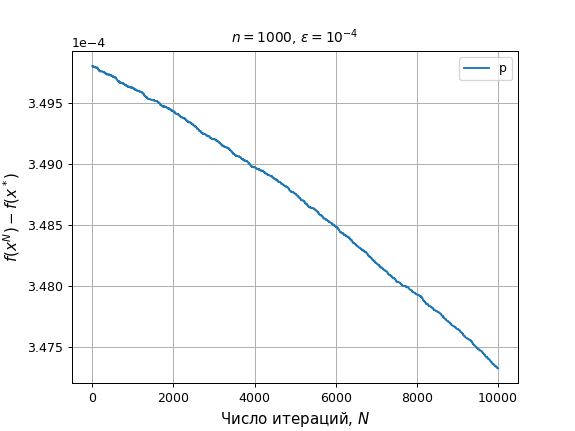

In [38]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k+1), plt1, label = 'p')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x^N)- f(x^*) $", fontsize=12)
plt.title(r"$n = 1000, \, \varepsilon = 10^{-4}$", fontsize = 11);
plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


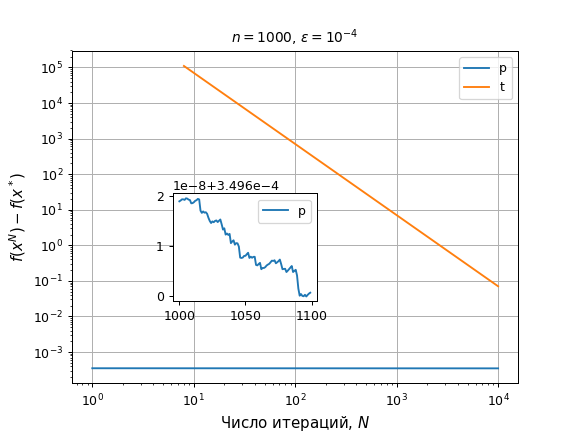

  adjustable: [ 'box' | 'datalim' | 'box-forced'] 
  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  anchor: unknown
  animated: [True | False] 
  aspect: unknown
  autoscale_on: unknown
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes: an :class:`~matplotlib.axes.Axes` instance 
  axes_locator: unknown
  axisbelow: [ *True* | *False* | 'line' ] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color_cycle: unknown
  contains: a callable function 
  facecolor: unknown
  fc: unknown
  figure: unknown
  frame_on: [ *True* | *False* ] 
  gid: an id string 
  label: string or anything printable with '%s' conversion. 
  navigate: [ *True* | *False* ] 
  navigate_mode: unknown
  path_effects: unknown
  picker: [None|float|boolean|callable] 
  position: unknown
  rasterization_zorder

In [65]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k+1), plt1, label = 'p')
theor_estimate = [4*math.ceil(Vx0)*C_const*L/N/N  for N in range(8, k + 1)]
plt.plot(range(8, k + 1), theor_estimate, label='t')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x^N) - f(x^*) $", fontsize=12)
plt.title(r"$n = 1000, \, \varepsilon = 10^{-4}$", fontsize = 11)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()

# Generate data for the zoomed portion
X_detail = range(1000, 1100)
Y_detail = [plt1[y] for y in X_detail]

 # location for the zoomed portion 
sub_axes = plt.axes([0.3, 0.3, 0.25, 0.25]) 

# plot the zoomed portion
sub_axes.plot(X_detail, Y_detail, label = 'p')#, c = 'k') 
sub_axes.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
sub_axes.legend()

# insert the zoomed figure
plt.setp(sub_axes)

plt.show()